In [121]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Generate_data_activity import Generate_data
from Manifold_Analysis import Manifold_analysis
from CCA_analysis import CCA_Analysis
sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif")

from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import seaborn as sns
import cv2
from tabulate import tabulate
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation
import matplotlib.pyplot as plt    
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


In [5]:
class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
        

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)    

# Generate Data with A2C model

In [6]:
LENGTH_TRIAL = 500
EPISODES = 10

Generate_DATA = Generate_data(device)
Liste_activation,Final_score,Liste_position_agent,Liste_position_alien,Liste_action_agent= Generate_DATA.run_episodes(structure_network = "a2c",length_trial = LENGTH_TRIAL,number_episode = EPISODES)

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_0_2.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_1000_2.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_2000_2.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_3000_2.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_4000_2.pt
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_5000_2.pt
/Users/charlottebeylier/D

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.



Episode :0 	Agent number :0 	Final score: 165.00 	Number of steps: 794
Episode :1 	Agent number :0 	Final score: 105.00 	Number of steps: 629
Episode :2 	Agent number :0 	Final score: 180.00 	Number of steps: 704
Episode :3 	Agent number :0 	Final score: 170.00 	Number of steps: 995
Episode :4 	Agent number :0 	Final score: 155.00 	Number of steps: 663
Episode :5 	Agent number :0 	Final score: 110.00 	Number of steps: 471
Episode :5 	Agent number :0 	Final score: 215.00 	Number of steps: 1153
Episode :6 	Agent number :0 	Final score: 135.00 	Number of steps: 618
Episode :7 	Agent number :0 	Final score: 110.00 	Number of steps: 703
Episode :8 	Agent number :0 	Final score: 155.00 	Number of steps: 739
Episode :9 	Agent number :0 	Final score: 125.00 	Number of steps: 562
Episode :0 	Agent number :1 	Final score: 180.00 	Number of steps: 729
Episode :1 	Agent number :1 	Final score: 45.00 	Number of steps: 366
Episode :1 	Agent number :1 	Final score: 65.00 	Number of steps: 416
Episod

## Preprocessing

In [66]:
Names_hook = ["Conv_1","Conv_2","Conv_3","fc1"]
analysis = Manifold_analysis(LENGTH_TRIAL)
Prepro_length = True
activity_layer = [[[[] for i in range(len(Names_hook))] for j in range(9)] for episode in range(EPISODES)]

for agent_number in range(9):
    print(agent_number)
    for layer in range(len(Names_hook)):
        for episode in range(EPISODES):
            activity_layer[episode][agent_number][layer] = analysis.prepro(Liste_activation[episode][agent_number][layer],Prepro_length)

0
1
2
3
4
5
6
7
8


## Selection of the episode, agent and layer to study

In [45]:
episode = 0
agent = 5
layer = 2

# PCA Analysis

## PCA of the data

In [72]:
List_couple_PC = [[[[] for i in range(len(Names_hook))]for pc in range(2)] for agent_number in range(9)]
List_couple_PC_value = [[[[] for i in range(len(Names_hook))]for pc in range(2)]for agent_number in range(9)]


Liste_table_X = ['PC1','PC2','PC3','PC4','PC5']
Liste_table_Y = ["Alien_Position"]

for agent in range(9):
    for episode in range(EPISODES):
        for i in range(len(Names_hook)):    
            cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent][i],Liste_position_agent[episode][agent],Liste_position_alien[episode][agent],Liste_action_agent[episode][agent])
            corr_df= cca_analysis.df.corr(method='pearson') 
            #print(corr_df["Alien_Position"].max)
            a = corr_df["Alien_Position"].to_numpy()
            PC_first = np.argsort(np.abs(a))[6]
            PC_second = np.argsort(np.abs(a))[5]
            List_couple_PC[agent][0][i].append(PC_first)
            List_couple_PC[agent][1][i].append(PC_second)
            List_couple_PC_value[agent][0][i].append(np.abs(a[PC_first]))
            List_couple_PC_value[agent][1][i].append(np.abs(a[PC_second]))
            # plt.figure(figsize=(10,8))
            # X_df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
            # sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
            # plt.title(agent_number)
            # plt.tight_layout()


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/an

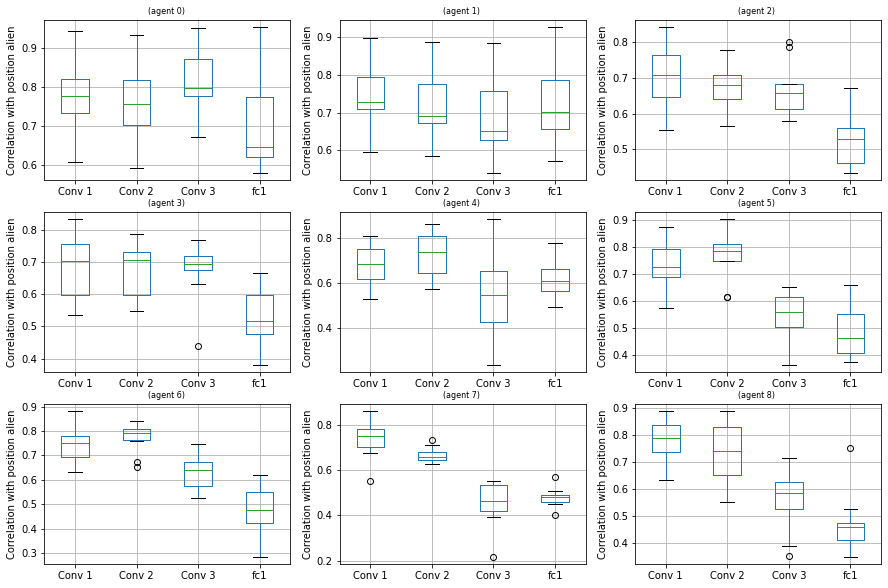

In [88]:
fig = plt.figure(figsize=(15,10))
for agent in range(9):
    data_pcvalue1 = {'Conv 1':List_couple_PC_value[agent][0][0],'Conv 2':List_couple_PC_value[agent][0][1],'Conv 3':List_couple_PC_value[agent][0][2],'fc1':List_couple_PC_value[agent][0][3]}  
    data_pcvalue2 = {'Conv 1':List_couple_PC_value[agent][1][0],'Conv 2':List_couple_PC_value[agent][1][1],'Conv 3':List_couple_PC_value[agent][1][2],'fc1':List_couple_PC_value[agent][1][3]}  
    df_pcvalue1 = pd.DataFrame(data_pcvalue1, index =[str(i) for i in range(EPISODES)])  
    df_pcvalue2 = pd.DataFrame(data_pcvalue2, index =[str(i) for i in range(EPISODES)])
    
    ax = fig.add_subplot(3,3,agent+1)
    boxplot = df_pcvalue1.boxplot(column=["Conv 1","Conv 2","Conv 3","fc1"])
    ax.set_title("(agent %s) " % (agent), fontsize=8) 
    ax.set_ylabel("Correlation with position alien")
    # ax = fig.add_subplot(1,2,2)
    # boxplot = df_pcvalue2.boxplot(column=["Conv 1","Conv 2","Conv 3","fc1"]) 
    # plt.title("Second major component") 
    # ax.set_ylabel("Correlation with position alien")

    plt.savefig("Boxplot_first_second_najor_component_agent_5.jpg",
                        format='jpeg',
                        dpi=100)
        

In [49]:
Liste_score = [[]for i in range(9)]

for agent in range(9):
    for episode in range(EPISODES):
        Liste_score[agent].append(Final_score[episode][agent][0])

print(len(Liste_score))

9


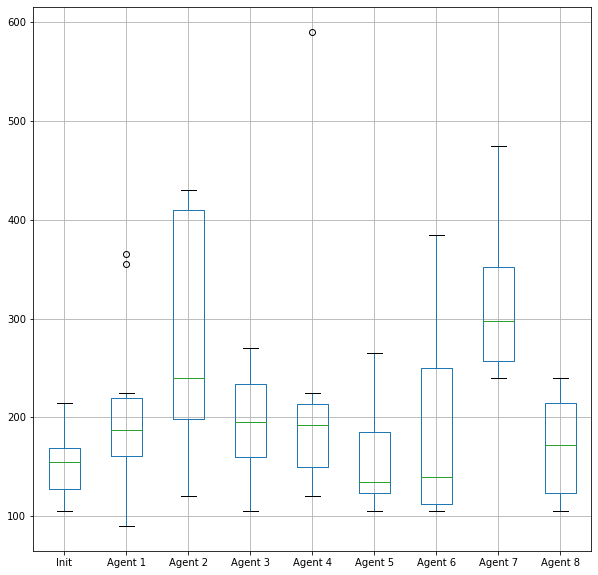

In [50]:
plt.figure(figsize=(10,10))
data_score = {'Init':Liste_score[0],'Agent 1':Liste_score[1],'Agent 2':Liste_score[2],'Agent 3':Liste_score[3],'Agent 4':Liste_score[4],'Agent 5':Liste_score[5],'Agent 6':Liste_score[6],'Agent 7':Liste_score[7],'Agent 8':Liste_score[8]}  
df_score = pd.DataFrame(data_score, index =[str(i) for i in range(EPISODES)])  

boxplot = df_score.boxplot(column=['Init','Agent 1','Agent 2','Agent 3','Agent 4','Agent 5','Agent 6','Agent 7','Agent 8']) 

# CCA Analysis

# Correlation between PCA components and latent variables

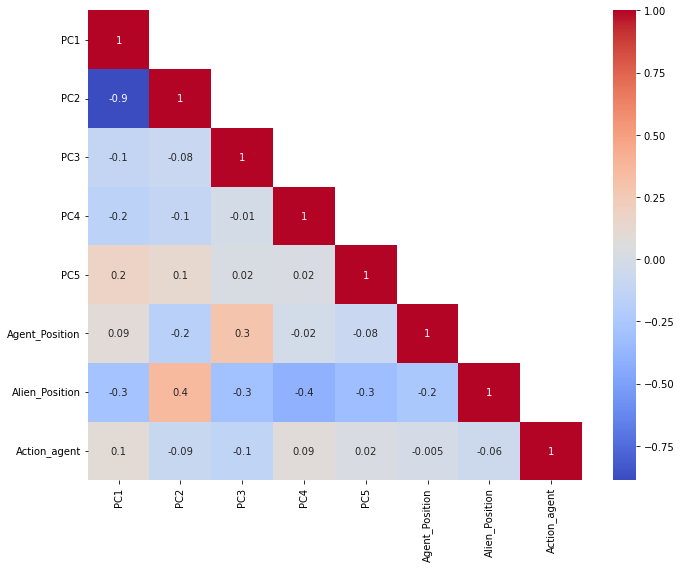

In [51]:
corr_df= cca_analysis.df.corr(method='pearson') 

plt.figure(figsize=(10,8))
X_df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()
plt.savefig("Heatmap_Canonical_Correlates_from_X_and_data.jpg",
                    format='jpeg',
                    dpi=100)


## Comparison of the PCA components with the Alien Position

In [54]:
episode = 0
agent = 0
layer = 0

Liste_table_X = ['PC1','PC2','PC3','PC4','PC5']
Liste_table_Y = ["Alien_Position","Agent_Position"]

cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][layer],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])

print("The correlation between the first pair of canonical variables is :",cca_analysis.coeff_corr_first_pair)
print("The correlation between the second pair of canonical variables is :",cca_analysis.coeff_corr_second_pair)

The correlation between the first pair of canonical variables is : 0.9377533806924118
The correlation between the second pair of canonical variables is : nan


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 2]. n_components=2 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,


## Comparison of the PCA components with the Agent Position

In [55]:
Liste_table_X = ['PC1','PC2','PC3','PC4','PC5']
Liste_table_Y = ["Agent_Position"]

cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][layer],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])

print("The correlation between the first pair of canonical variables is :",cca_analysis.coeff_corr_first_pair)
print("The correlation between the second pair of canonical variables is :",cca_analysis.coeff_corr_second_pair)

The correlation between the first pair of canonical variables is : 0.35266347257465125
The correlation between the second pair of canonical variables is : nan


/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,


# Correlation between components 3 and 4 and alien position

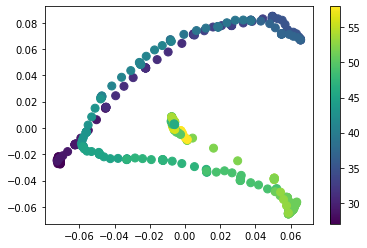

In [57]:

plt.figure()
plt.scatter(cca_analysis.pca.components_[1],cca_analysis.pca.components_[4], marker='o', c = Liste_position_alien[episode][agent_number][0:500], s = 64) 
plt.colorbar()
#plt.scatter(pca.components_[3],pca.components_[4])

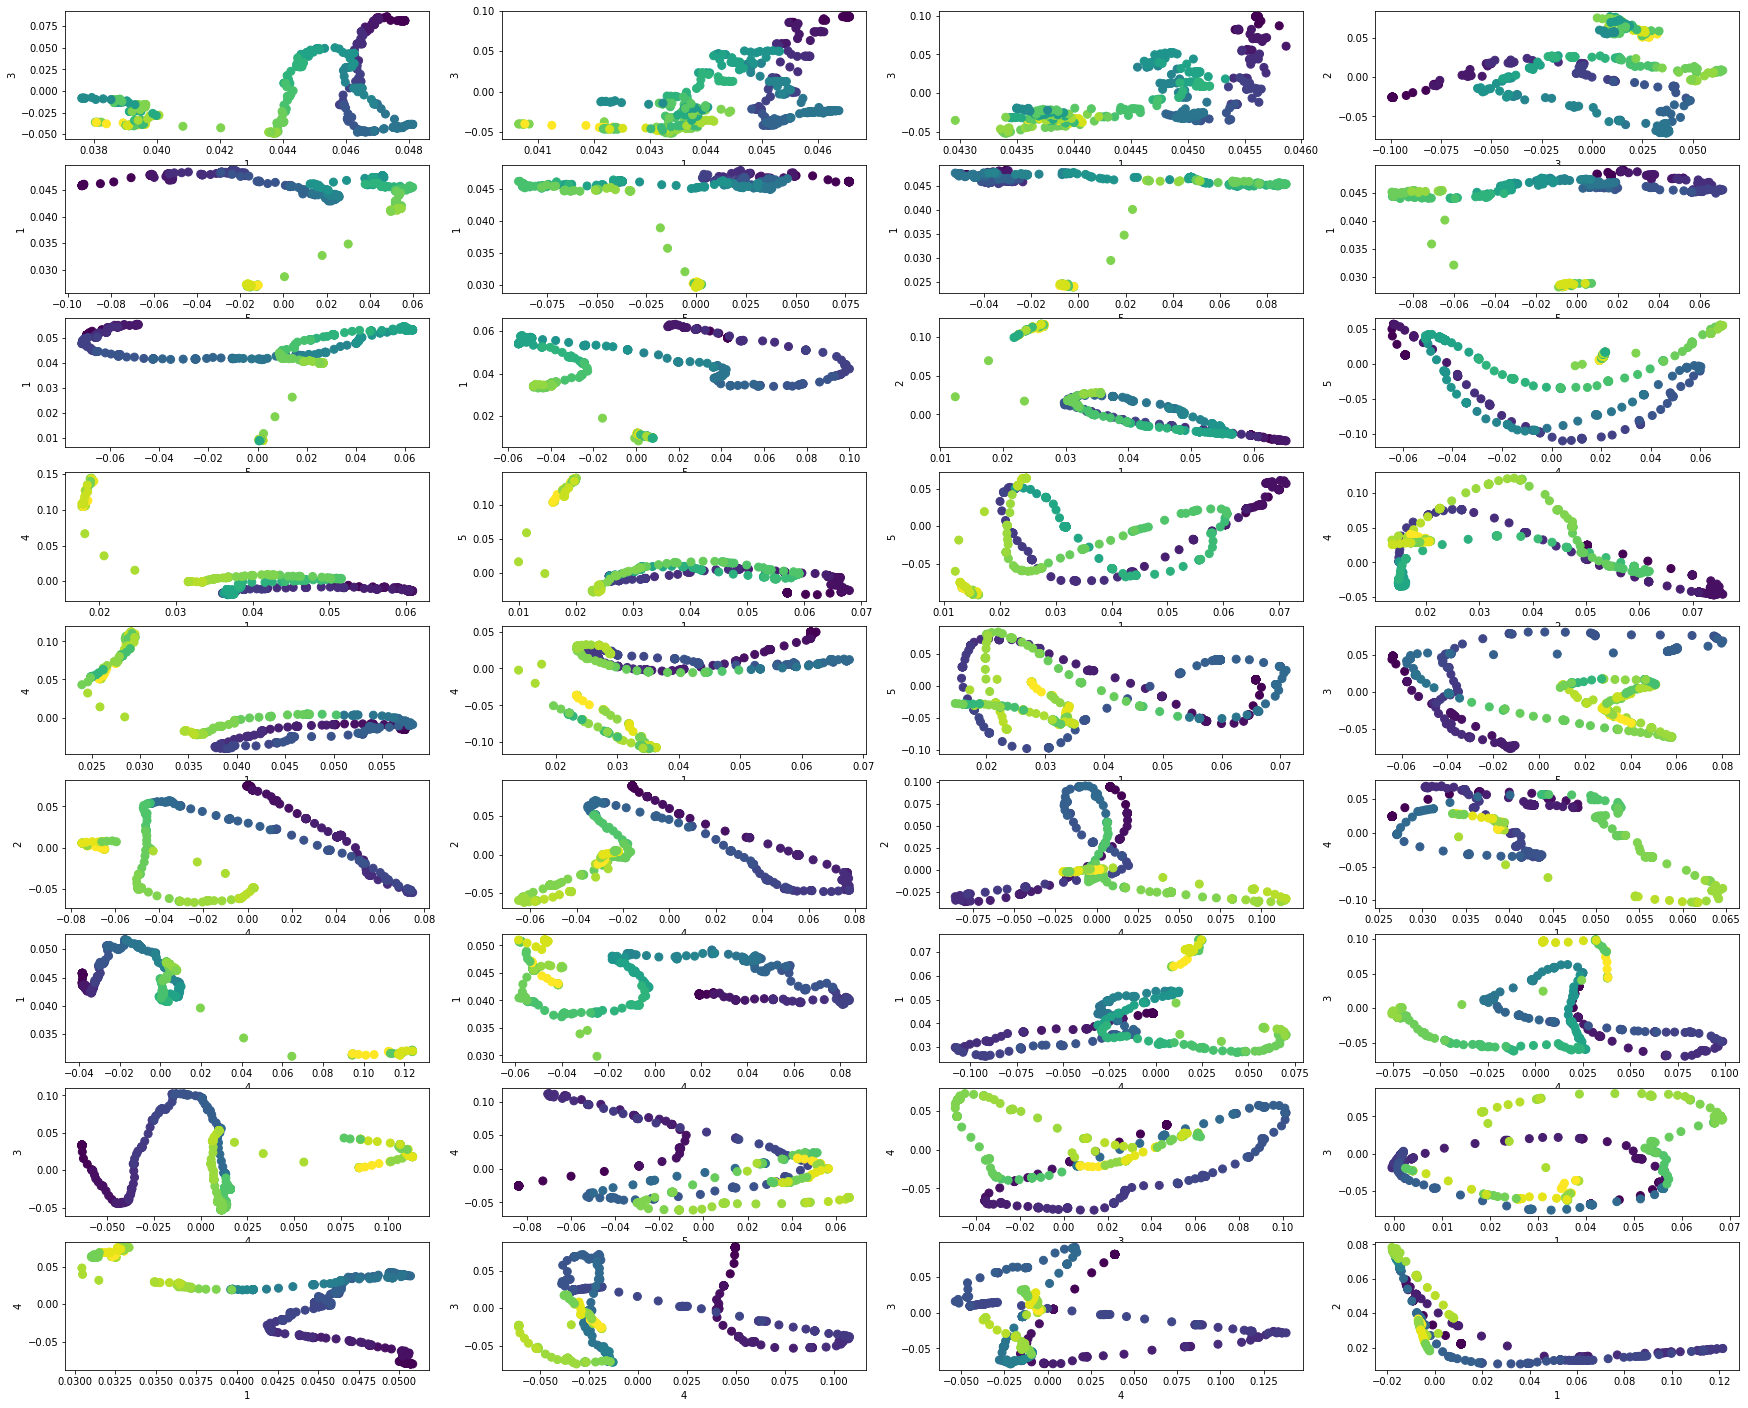

In [124]:
j=1
episode = 2
fig = plt.figure(figsize=(30,25))
for agent_number in range(9):
    for i in range(len(Names_hook)):
        cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
        corr_df= cca_analysis.df.corr(method='pearson') 
        #print(corr_df["Alien_Position"].max)
        a = corr_df["Alien_Position"].to_numpy()[0:5]
        #print(np.argsort(np.abs(a)))
        PC_first = np.argsort(np.abs(a))[4]
        PC_second = np.argsort(np.abs(a))[3]
        #print("PC_first",PC_first)
        #print("PC_second",PC_second)
        ax = fig.add_subplot(9,len(Names_hook),j)
        ax.scatter(cca_analysis.pca.components_[PC_first],cca_analysis.pca.components_[PC_second], marker='o', c = Liste_position_alien[episode][agent_number][0:500], s = 64) 
        ax.set_xlabel(str(PC_first+1))
        ax.set_ylabel(str(PC_second+1))
        # if i == 3:
        #     ax.set_title("(agent %s) %s" % (agent_number, Names_hook[i]))           # plt.suptitle(table[agent_number][0], fontsize=20)
        
            
        j+=1
        #print(j)

# Impact of the training on the correlation

In [70]:

Liste_table_X = ['PC4','PC5']
Liste_table_Y = ["Alien_Position"]
table = [["Init"],["1000"],["2000"],["3000"],["4000"],["5000"],["6000"],["7000"],["8000"]]


for agent_number in range(9):
    for i in range(len(Names_hook)):
        liste = []
        for episode in range(EPISODES):
            cca_analysis = CCA_Analysis(Liste_table_X,Liste_table_Y,LENGTH_TRIAL,activity_layer[episode][agent_number][i],Liste_position_agent[episode][agent_number],Liste_position_alien[episode][agent_number],Liste_action_agent[episode][agent_number])
            liste.append(cca_analysis.coeff_corr_first_pair)
        table[agent_number].append(np.mean(liste)) 
    table[agent_number].append(np.mean(Liste_score[agent_number]))    
 

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:252: FutureWarning: As of version 0.24, n_components(500) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
/opt/an

In [71]:
print(tabulate(table, headers=["# Training Epoch","Conv_1","Conv_2","Conv_3","fc1","Average Score"],tablefmt ="fancy_grid"))

╒════════════════════╤══════════╤══════════╤══════════╤══════════╤═════════════════╕
│ # Training Epoch   │   Conv_1 │   Conv_2 │   Conv_3 │      fc1 │   Average Score │
╞════════════════════╪══════════╪══════════╪══════════╪══════════╪═════════════════╡
│ Init               │ 0.427682 │ 0.425183 │ 0.376515 │ 0.377112 │           151.5 │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 1000               │ 0.414383 │ 0.617189 │ 0.552249 │ 0.588828 │           205.5 │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 2000               │ 0.462883 │ 0.527037 │ 0.363333 │ 0.518533 │           279.5 │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 3000               │ 0.53812  │ 0.763885 │ 0.606788 │ 0.559378 │           192   │
├────────────────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┤
│ 4000               │ 0.576906 │ 0.85632  │ 0.522903 │ 0.674531 

In [118]:
L_threshold = [[[] for i in range(len(Names_hook))] for j in range(9)] 


for agent_number in range(9):    
    for episode in range(EPISODES):
        for i in range(len(Names_hook)):
            X = np.transpose(activity_layer[episode][agent_number][i])
            pca = PCA(n_components = 20) #we have 20 features
            pca.fit(X)
            variance = pca.explained_variance_ratio_ #calculate variance ratios
            var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
            #print(var)
            #var #cumulative sum of variance explained with [n] features
            threshold = [h for h in range(len(var)) if var[h]>80]
            L_threshold[agent_number][i].append(threshold[0])


In [114]:
print(len(L_threshold[0][0]))
print(table[8])

10
['8000']


In [120]:
table = [["Init"],["1000"],["2000"],["3000"],["4000"],["5000"],["6000"],["7000"],["8000"]]

for agent_number in range(9):
    for i in range(len(Names_hook)):
        table[agent_number].append(np.mean(L_threshold[agent_number][i]))
    
    table[agent_number].append(np.mean(Liste_score[agent_number]))   

        
print(tabulate(table, headers=["# Training Epoch","Conv_1","Conv_2","Conv_3","fc1","Average Score"],tablefmt ="fancy_grid"))

╒════════════════════╤══════════╤══════════╤══════════╤═══════╤═════════════════╕
│ # Training Epoch   │   Conv_1 │   Conv_2 │   Conv_3 │   fc1 │   Average Score │
╞════════════════════╪══════════╪══════════╪══════════╪═══════╪═════════════════╡
│ Init               │      2.6 │      1   │      0   │     0 │           151.5 │
├────────────────────┼──────────┼──────────┼──────────┼───────┼─────────────────┤
│ 1000               │      3   │      0.5 │      0   │     0 │           205.5 │
├────────────────────┼──────────┼──────────┼──────────┼───────┼─────────────────┤
│ 2000               │      3.6 │      3   │      2   │     1 │           279.5 │
├────────────────────┼──────────┼──────────┼──────────┼───────┼─────────────────┤
│ 3000               │      4   │      2.6 │      2   │     1 │           192   │
├────────────────────┼──────────┼──────────┼──────────┼───────┼─────────────────┤
│ 4000               │      3.7 │      2.8 │      2   │     1 │           220   │
├───────────────